## Use Case 1
Here are the steps for the use case 1
1. Load data
2. chain 2 data transformation and a model training
3. store the graph
4. open a new workload
5. load the history graph
6. write the exact same transformations and model training
7. the model should be fetched from the history graph instead being executed

In this use case, each workload has only one call to .data()

In [ ]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
root_data = ROOT_PACKAGE_DIRECTORY + '/data'


sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.execution_environment import ExecutionEnvironment

DATABASE_PATH = root_data + '/experiment_graphs/optimizer_test/uc1'

## Example 1
a chain of operations

In [ ]:
# Simple Case: Chain of 4 operations (No Merge or Branch)

# Create Execution Environment
ee = ExecutionEnvironment('dedup')
# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3
max_cols = train.max()

# Execute
data_main = max_cols.data(verbose = 0)

# Save history graph
ee.save_history(DATABASE_PATH, overwrite=True)
# Plot workload graph
ee.workload_graph.plot_graph(plt, edge_oper=True)


######### NEW WORKLOAD ############

# Create new environment
ee_2 = ExecutionEnvironment('dedup')
# Load the history graph
ee_2.load_history(DATABASE_PATH)
# Simple Case: Chain of 4 operations

# Load Data
train = ee_2.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3
max_cols = train.max()

# Execute
data_second_workload = max_cols.data(verbose = 1)

del ee
del ee_2

## Example 2
A workload with one predictive model and one preprocessing model containing multiple combine and split operations.

In [ ]:
# Use Case: Chain of 3 Transformations and 1 Model Building (includes two merges in total)
# Create Execution Environment
ee = ExecutionEnvironment('dedup')

# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train_labels = train['class']
train = train.drop(columns=['class'])

# Transformation 3
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
data = train.data(verbose=1)

# Model Training
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
random_forest.fit(train, train_labels)

# Execute
random_forest.trained_node.data()

# Save history graph
ee.save_history(DATABASE_PATH, overwrite=True)
# Plot workload graph
ee.workload_graph.plot_graph(plt, edge_oper=True)

In [ ]:
ee_2 = ExecutionEnvironment('dedup')
ee_2.load_history(DATABASE_PATH)

In [ ]:
# Load Data
train = ee_2.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train_labels = train['class']
train = train.drop(columns=['class'])

# Transformation 3
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)

# Model Training
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
random_forest.fit(train, train_labels)

# Execute
random_forest.trained_node.data(verbose=1)

## Use Case 2
Simple workload with multiple .data() calls

In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
root_data = ROOT_PACKAGE_DIRECTORY + '/data'


sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.execution_environment import ExecutionEnvironment

DATABASE_PATH = root_data + '/experiment_graphs/optimizer_test/uc2'

## Example 1
A chain of operations similar to use case one, but with two data calls.

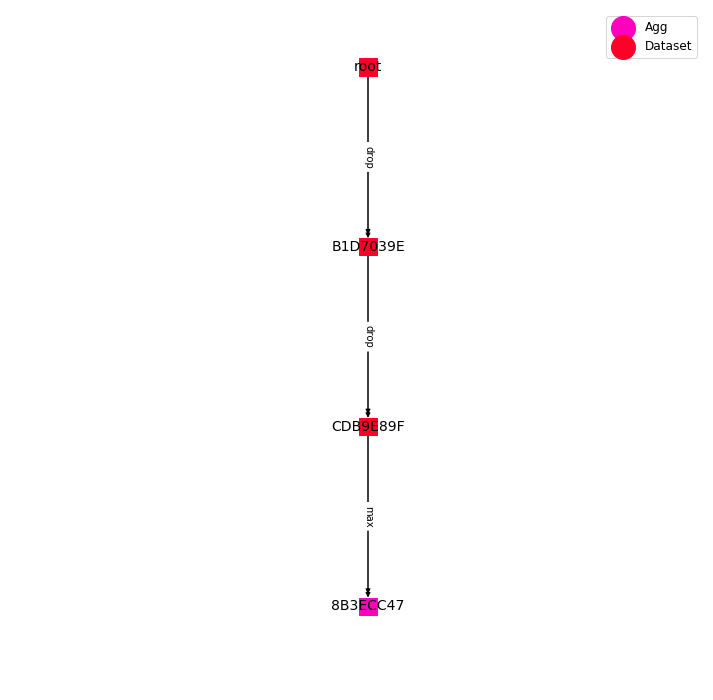

In [2]:
# Simple Case: Chain of 4 operations (No Merge or Branch)

# Create Execution Environment
ee = ExecutionEnvironment('dedup')
# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])

# Transformation 3
max_cols = train.max()

# Execute
data_main = max_cols.data(verbose = 0)

# Save history graph
ee.save_history(DATABASE_PATH, overwrite=True)
# Plot workload graph
ee.workload_graph.plot_graph(plt, labels_for_vertex=['id'])

In [ ]:
# Create new environment
ee_2 = ExecutionEnvironment('dedup')
# Load the history graph
ee_2.load_history(DATABASE_PATH)

In [3]:
###### First .data() call #######

# Simple Case: Chain of 4 operations

# Load Data
train = ee_2.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train = train.drop(columns=['class'])
data = train.data()

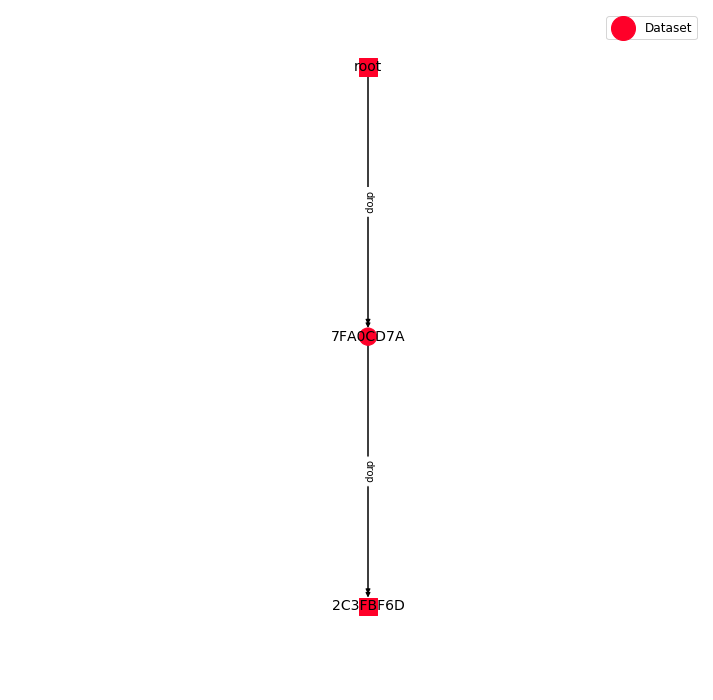

In [4]:
ee_2.workload_graph.plot_graph(plt, labels_for_vertex=['id'], labels_for_edges=['name'])

In [5]:
##### Second .data() call #####

# Transformation 3
max_cols = train.max()

# Execute
data_second_workload = max_cols.data(verbose = 1)

workload graph size: 2
existing materialized nodes {'2C3FBF6D': 'CDB9E89F'}
new materialized nodes {'F0A829C4': '8B3ECC47'}
optimized workload graph size: 0


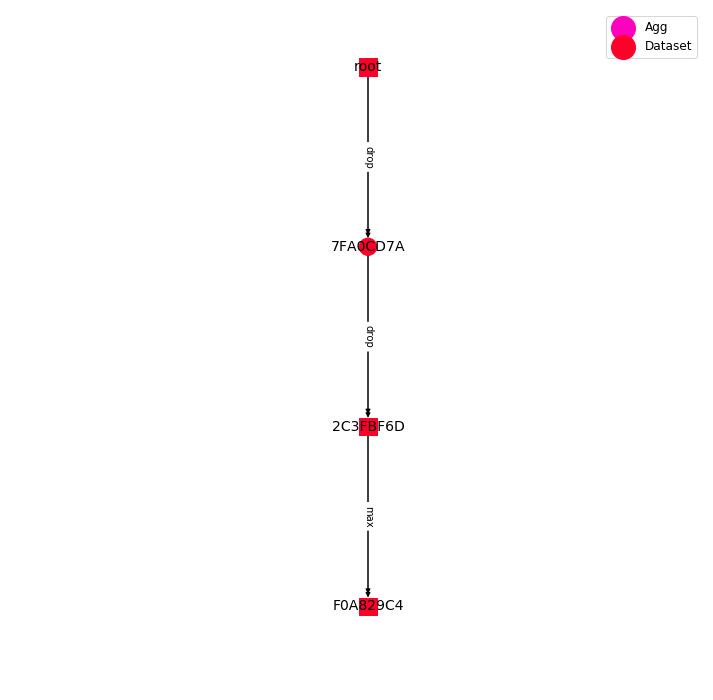

In [6]:
ee_2.workload_graph.plot_graph(plt, labels_for_vertex=['id'], labels_for_edges=['name'])

In [9]:
del ee
del ee_2

## Example 2
Model training with multiple calls

In [2]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
root_data = ROOT_PACKAGE_DIRECTORY + '/data'


sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.execution_environment import ExecutionEnvironment

DATABASE_PATH = root_data + '/experiment_graphs/optimizer_test/uc2'

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


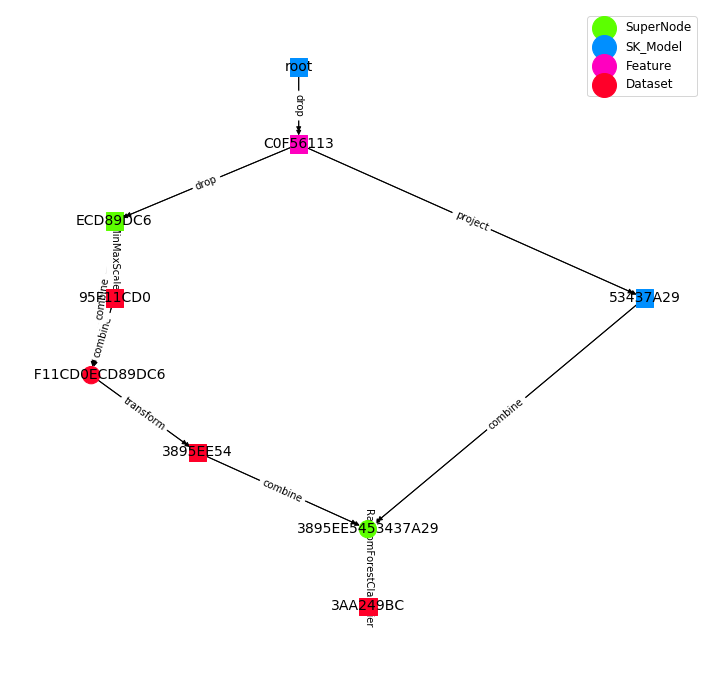

In [3]:
# Use Case: Chain of 3 Transformations and 1 Model Building (includes two merges in total)
# Create Execution Environment
ee = ExecutionEnvironment('dedup')

# Load Data
train = ee.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train_labels = train['class']
train = train.drop(columns=['class'])

# Transformation 3
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)

# Model Training
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
random_forest.fit(train, train_labels)

# Execute
random_forest.trained_node.data()

# Save history graph
ee.save_history(DATABASE_PATH, overwrite=True)
# Plot workload graph
ee.workload_graph.plot_graph(plt,labels_for_vertex=['id'])

In [4]:
# Create new environment
ee_2 = ExecutionEnvironment('dedup')
# Load the history graph
ee_2.load_history(DATABASE_PATH)

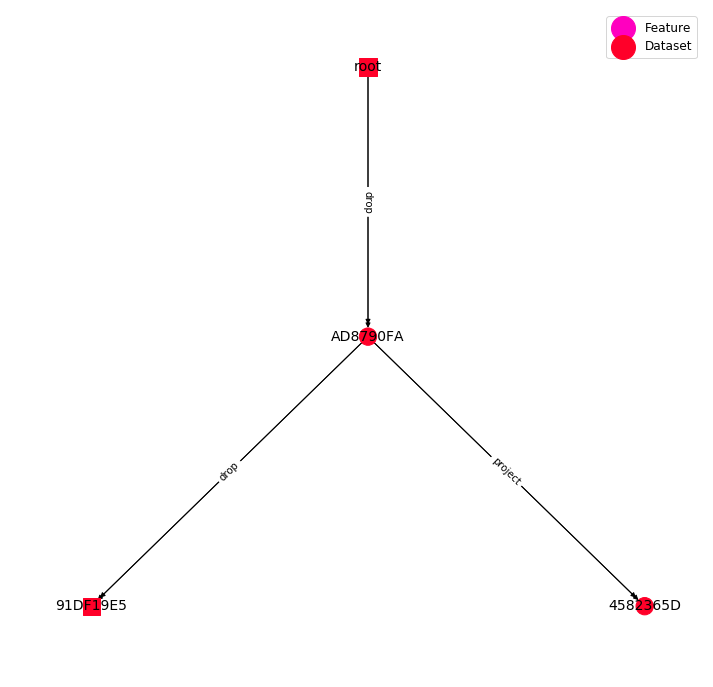

In [5]:
##### 1st .data() call ######
# Load Data
train = ee_2.load(root_data + '/openml/task_id=31/train.csv')

# Transformation 1
train = train.drop(columns=['checking_status'])

# Transformation 2
train_labels = train['class']
train = train.drop(columns=['class'])
train.data()
ee_2.workload_graph.plot_graph(plt, labels_for_vertex=['id'], labels_for_edges=['name'])

workload graph size: 4
existing materialized nodes {'91DF19E5': 'ECD89DC6'}
new materialized nodes {'982DB09C': '3895EE54'}
optimized workload graph size: 0


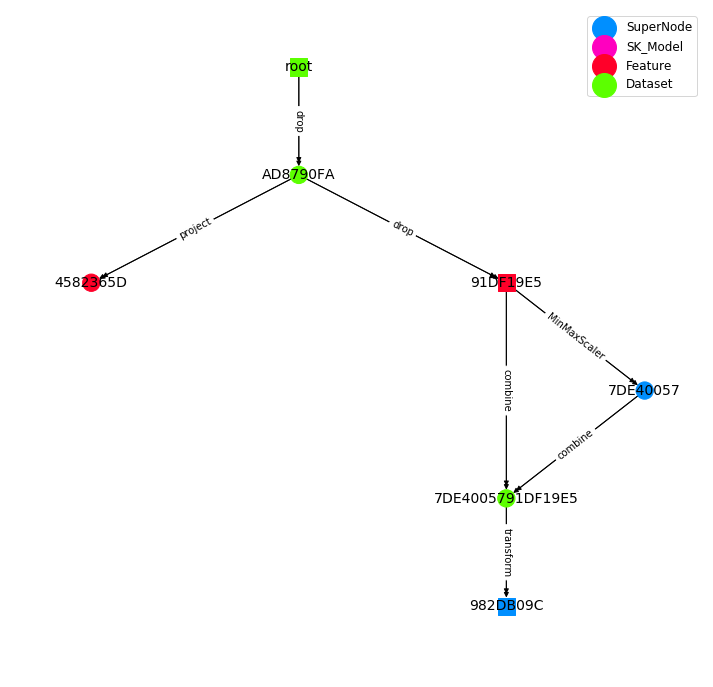

In [6]:
##### 2st .data() call ######
# Transformation 3
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
data = train.data(verbose=1)
ee_2.workload_graph.plot_graph(plt, labels_for_vertex=['id'], labels_for_edges=['name'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


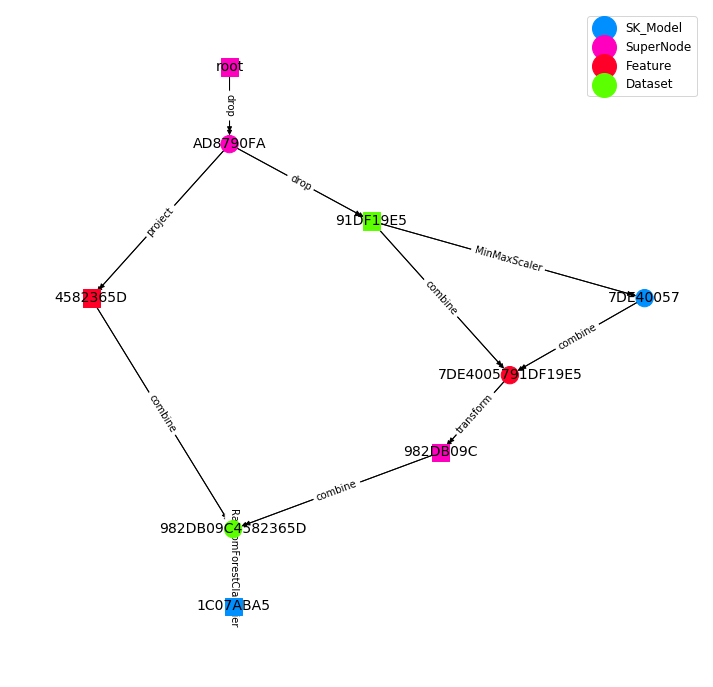

In [7]:
##### 3rd .data() call ######
# Model Training
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
random_forest.fit(train, train_labels)

# Execute
random_forest.trained_node.data()
ee_2.workload_graph.plot_graph(plt, labels_for_vertex=['id'], labels_for_edges=['name'])